[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/00_preprocesamiento_dataset_clasificacion.ipynb)



# Preparación y preprocesamiento de datos del dataset Ninapro DB1

## Descripción corta del dataset

> **Importante**: Esta información debe ser actualizada (Pues fue tomada de cosas viejas).

*Ninapro* ([link](https://ninapro.hevs.ch/)) es un base de datos publica destinada a fomentar la investigación de aprendizaje automático en manos humanas, robóticas y protésicas. *Ninapro* posee 10 datasets que incluyen 180 adquisiciones de datos de sujetos sanos y con amputacion transradial (debajo del codo). 

En este caso especifico, se seleccionó el dataset [DB1](https://ninapro.hevs.ch/instructions/DB1.html) el cual se describe brevemente en la siguiente tabla:

| Columna                     | Descripción                                                   | Ejemplo                |
|:----------------------------|:--------------------------------------------------------------|:-----------------------|
| `Subject`                   | Sujeto                                                        | 01                     |
| `Hand`                      | Mano                                                          | Intact                 |
| `Handedness`                | Lateralidad                                                   | Right / Left           |
| `Gender`                    | Genero                                                        | Male / Female          |
| `Age`                       | Edad                                                          | 31                     |
| `Height`                    | Altura                                                        | 170                    |
| `Weight`                    | Peso                                                          | 75                     |
| `zip files`                 | Archivos con las adquisición de los datos                     | s1.zip                 |

En DB1, existen 27 archivos comprimidos (`S1.zip`, `S2.zip`, ..., `S27.zip`) con la adquisición de datos de los sujetos. Cada archivo contiene un directorio con tres archivos MAT (Matlab) con el siguiente formado `Sx_Ay_Ez.mat` donde:
* **`x`**: Numero del sujeto (entre 1 y 27).
* **`y`**: Adquisición (A1: Primera adquisición).
* **`z`**: Numero del ejercicio: 1, 2 o 3.

Como nuestro trabajo solo se va a centrar en las posturas del ejercicio uno, solo nos va a interesar los archivos MAT de la forma `Sx_A1_E1.mat` de cada uno de los 27 sujetos.

## Objetivo a desarrollar

Obtener los datos de las posturas de interes.

## Resumen del proceso realizado

To do...

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal


In [5]:
import requests
from tqdm import tqdm
import os
import zipfile
import sys

In [6]:
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

## 2. Funciones

In [3]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
# from utils.funciones1 import multiple_plot
# from utils.funciones2 import test_hola, graficar_medida, graficar_medida2, filter_signal, \
#                             segmentar_data_base, aplanar_data_base, aplanar_ventana, \
#                             rms_value, mav_value, features_data_base

def find_value_ranges(arr, value):
    """
    Encuentra los rangos (inicio, fin) donde el valor dado aparece de forma continua en un array.

    Parámetros:
        arr (array-like): arreglo de entrada (lista o np.array).
        value (int o float): valor objetivo para encontrar bloques contiguos.

    Retorna:
        List[Tuple[int, int]]: lista de tuplas (inicio, fin) donde aparecen bloques del valor.
    """
    arr = np.asarray(arr)
    ranges = []
    in_range = False

    for i, val in enumerate(arr):
        if val == value and not in_range:
            start = i
            in_range = True
        elif val != value and in_range:
            end = i - 1
            ranges.append((start, end))
            in_range = False

    # Si termina en un bloque del valor
    if in_range:
        ranges.append((start, len(arr) - 1))

    return ranges

## 3. Carga y preprocesamiento del dataset original

Configuración inicial

In [7]:
# Agregar el directorio raíz del proyecto al PYTHONPATH
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Sube un nivel
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
print(f"Directorio raíz del proyecto agregado al PYTHONPATH: {ROOT_DIR}")

Directorio raíz del proyecto agregado al PYTHONPATH: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia


In [8]:
# se importan las rutas
# from globals import SRC_DIR, DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR
# Agregar el directorio SRC_DIR al PYTHONPATH
#if SRC_DIR not in sys.path:
#    sys.path.append(SRC_DIR)
from globals import RAW_DATA_DIR, PROCESSED_DATA_DIR, RAW_SUBSET_DATA_DIR
print(f"Ruta datos crudos: {RAW_DATA_DIR}")
print(f"Ruta datos procesados: {PROCESSED_DATA_DIR}")
print(f"Ruta de subconjunto de datos crudos: {RAW_SUBSET_DATA_DIR}")

Ruta datos crudos: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw
Ruta datos procesados: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\processed
Ruta de subconjunto de datos crudos: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset


### Carga de datos

Se cargan los datos de cada uno de los 27 usuarios en un diccionario.

In [10]:
# Listar y cargar los archivos .npy del directorio PROCESSED_DATA_DIR
npy_files = [f for f in os.listdir(PROCESSED_DATA_DIR) if f.endswith('.npy')]

data = {}
for file in npy_files:
    sub_i = file.split('_')[-1].split('.')[0]
    file_path = os.path.join(PROCESSED_DATA_DIR, file)
    data[sub_i] = np.load(file_path) 
    print(f"Archivo cargado: {file}")

Archivo cargado: data_ex3_subject_1.npy
Archivo cargado: data_ex3_subject_10.npy
Archivo cargado: data_ex3_subject_11.npy
Archivo cargado: data_ex3_subject_12.npy
Archivo cargado: data_ex3_subject_13.npy
Archivo cargado: data_ex3_subject_14.npy
Archivo cargado: data_ex3_subject_15.npy
Archivo cargado: data_ex3_subject_16.npy
Archivo cargado: data_ex3_subject_17.npy
Archivo cargado: data_ex3_subject_18.npy
Archivo cargado: data_ex3_subject_19.npy
Archivo cargado: data_ex3_subject_2.npy
Archivo cargado: data_ex3_subject_20.npy
Archivo cargado: data_ex3_subject_21.npy
Archivo cargado: data_ex3_subject_22.npy
Archivo cargado: data_ex3_subject_23.npy
Archivo cargado: data_ex3_subject_24.npy
Archivo cargado: data_ex3_subject_25.npy
Archivo cargado: data_ex3_subject_26.npy
Archivo cargado: data_ex3_subject_27.npy
Archivo cargado: data_ex3_subject_3.npy
Archivo cargado: data_ex3_subject_4.npy
Archivo cargado: data_ex3_subject_5.npy
Archivo cargado: data_ex3_subject_6.npy
Archivo cargado: data_

Se realizan verificaciones despues de la carga:

In [11]:
len(data)  # Mostrar la cantidad de archivos cargados

27

### Inspección de los datos cargados

Los datos por cada usuario son una matriz cuyas columnas se describen a continuación:

```
[ emg | restimulus | rerepetition ] = [ 0:9 | 10 | 11 ]
```

* **`restimulus`**: 1 - 23 (El reposo se toma como 0)
* **`rerepetition`**: 1 - 10

Con el fin de inspeccionar que se tenga coherencia en los datos cargados, se va a seleccionar un sujeto de muestra (sujeto 1) y se van a realizar las graficas de los datos se este.

In [12]:
INDEX_SUB = '1'
emg_s1 = data[INDEX_SUB][:,0:10]
restimulus_s1 = data[INDEX_SUB][:,10]
rerepetition_s1 = data[INDEX_SUB][:,11]

#### Grafica de las señales EMG del sujeto seleccionado

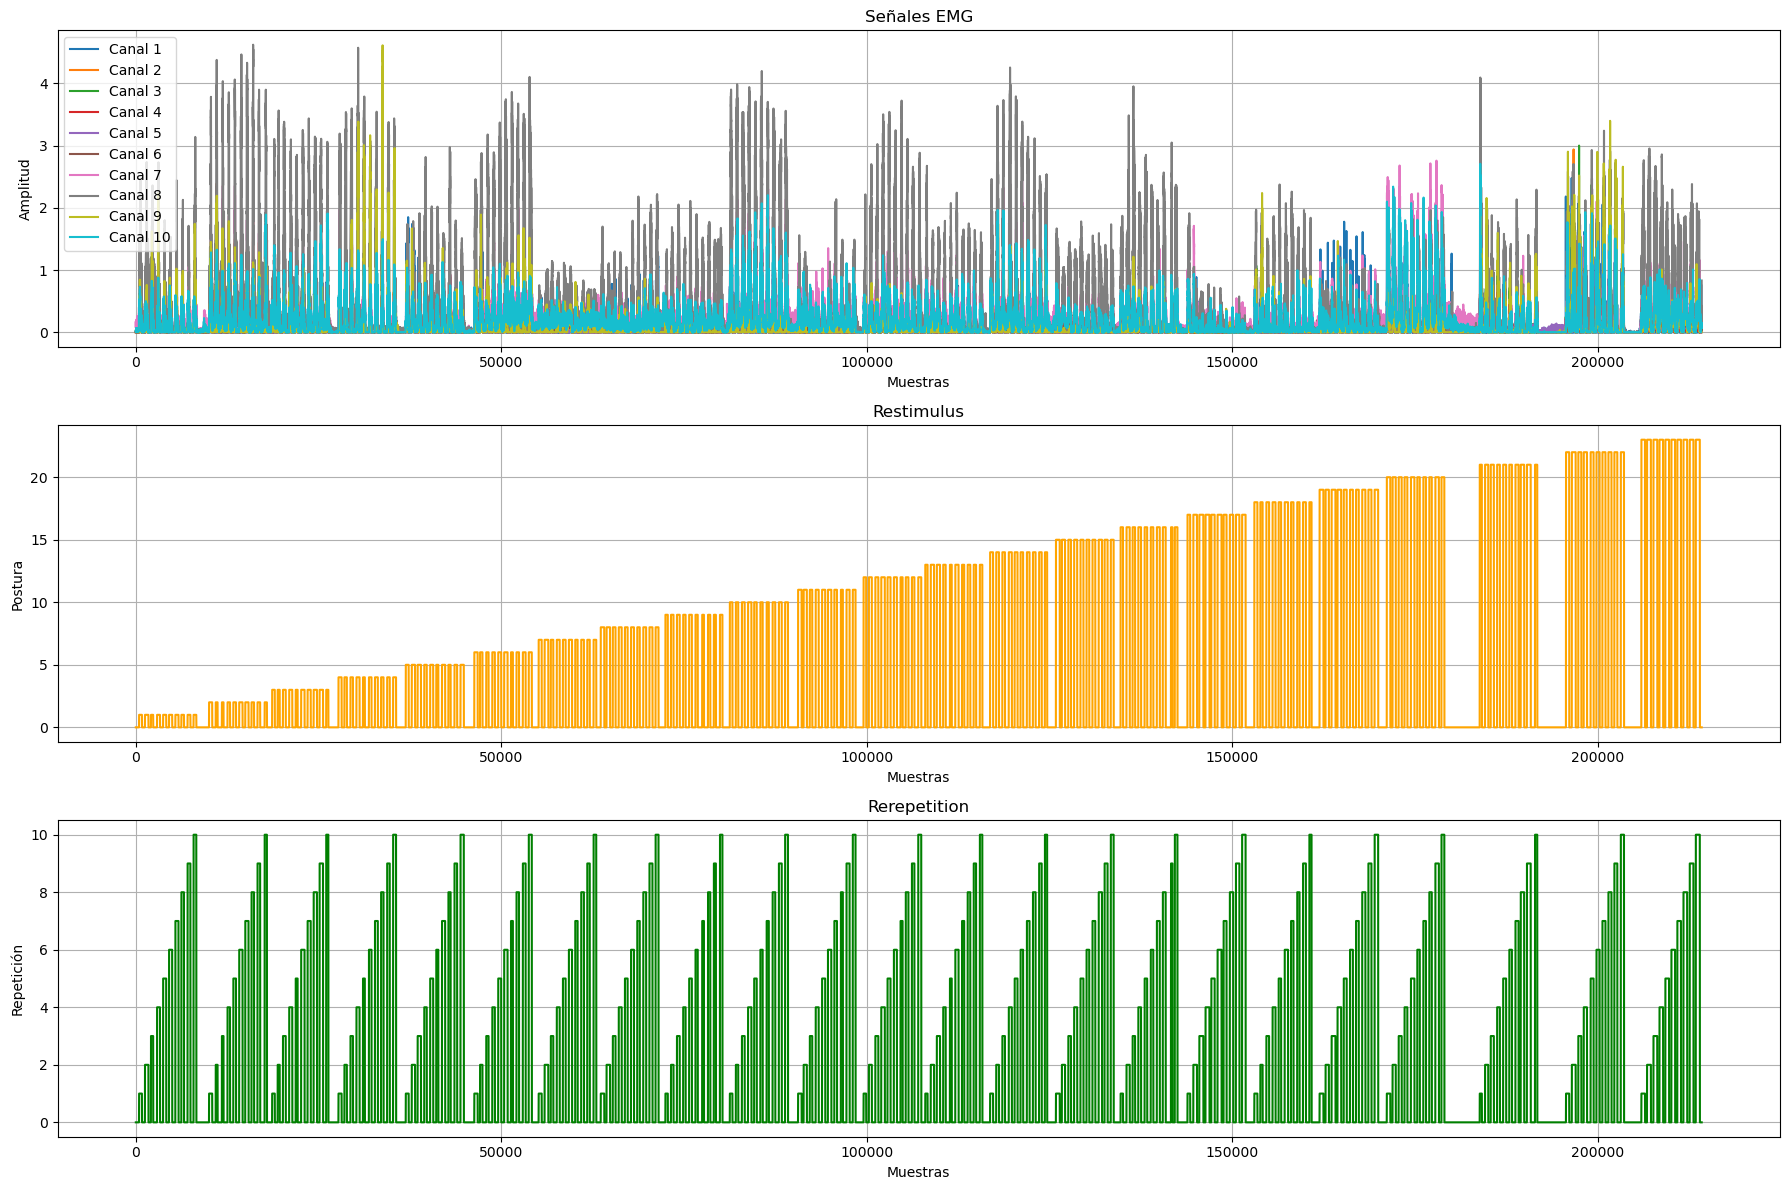

In [16]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1, color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1, color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [17]:
data[INDEX_SUB].shape  # Mostrar la forma de los datos cargados

(214236, 12)

In [18]:
num_exercise = 23
s1_23 = find_value_ranges(restimulus_s1,23)  # Buscar los rangos de bloques de valor 1 en 'restimulus_s1'
s1_23


[(205973, 206474),
 (206747, 207279),
 (207625, 208150),
 (208450, 208947),
 (209254, 209765),
 (210081, 210590),
 (210893, 211393),
 (211730, 212241),
 (212589, 213101),
 (213419, 213973)]

La siguiente función obtiene el rango de muestras asociadas a un ejercicio empleando un margen de puntos a la izquierda y a la derecha

In [28]:
def get_exercise_ranges(data, num_exercise, margins = (0,0)):
    """
    Obtiene los rangos de inicio y fin de un ejercicio específico en los datos.

    Parámetros:
        data (array-like): arreglo de datos que contiene información sobre ejercicios.
        num_exercise (int): número del ejercicio a buscar.
        margins (tuple): márgenes de inicio y fin para ajustar los índices (por defecto (0,0)).

    Retorna:
        List[Tuple[int, int]]: lista de tuplas (inicio, fin) donde aparecen bloques del ejercicio.
    """
    indexes = find_value_ranges(data, num_exercise)
    initial_idex = indexes[0][0]  # Primer índice de inicio
    final_idex = indexes[-1][1]  # Último índice de fin
    # Ajustar los índices con el margen
    initial_idex = max(0, initial_idex - margins[0])  # Asegurarse de no salir del rango
    final_idex = min(len(data) - 1, final_idex + margins[1])  # Asegurarse de no salir del rango
    return initial_idex, final_idex  # Retorna el rango del ejercicio específico

Como prueba se seleccionó el ejercicio 23

In [29]:
# Obtener los rangos de inicio y fin del ejercicio 23
ini_23, end_23 = get_exercise_ranges(restimulus_s1,23,(1000,100)) # 1000 puntos a la izquierda y derecha
# Mostrar los rangos
print(f"Rango del ejercicio 23: {ini_23} - {end_23}")

Rango del ejercicio 23: 204973 - 214073


A continuación, se resalta en la grafica la sección asociada a este ejercicio.

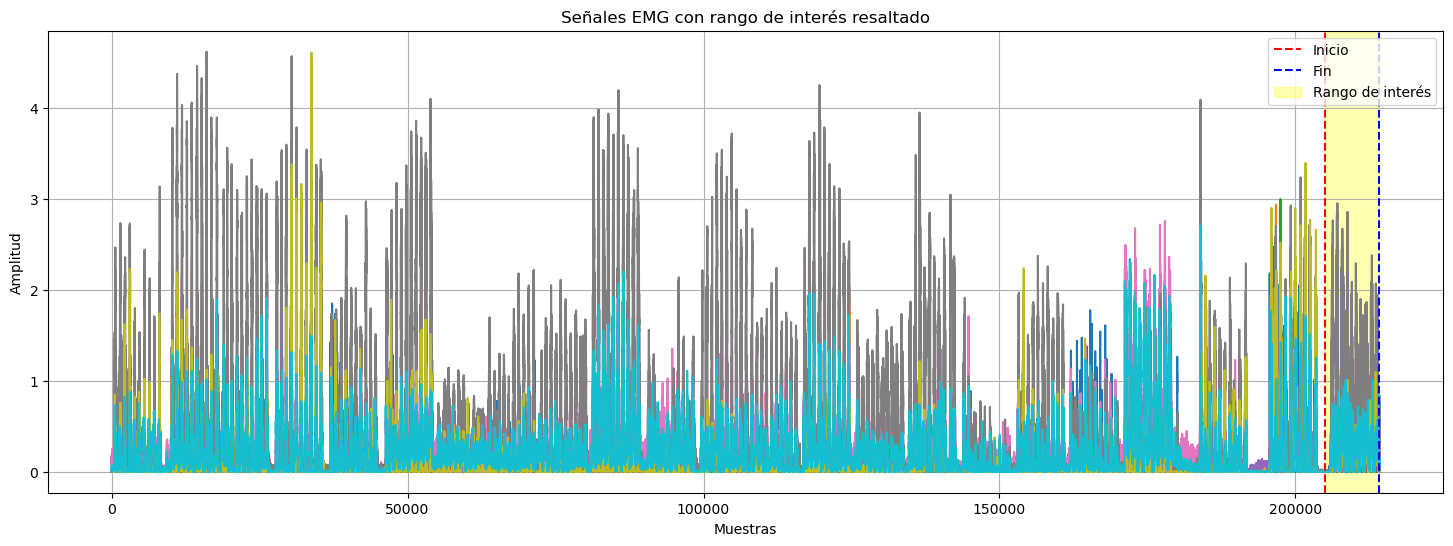

In [30]:
plt.figure(figsize=(18, 6))

# Graficar las señales EMG
for i in range(emg_s1.shape[1]):  # Iterar sobre cada canal de EMG
    # plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
    plt.plot(emg_s1[:, i])

# Agregar líneas verticales en ini_23 y end_23
plt.axvline(x=ini_23, color='red', linestyle='--', label='Inicio')
plt.axvline(x=end_23, color='blue', linestyle='--', label='Fin')

# Agregar un fondo claro entre las líneas
plt.axvspan(ini_23, end_23, color='yellow', alpha=0.3, label='Rango de interés')

# Configurar etiquetas y leyenda
plt.title('Señales EMG con rango de interés resaltado')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

A continuación se va a generalizar un poco mas el procedimiento permitiendo la elección de varias posturas.

In [32]:
def get_multiple_exercise_ranges(data, exercise_numbers, margins = (0,0)):
    """
    Obtiene los rangos de inicio y fin para múltiples ejercicios específicos en los datos.

    Parámetros:
        data (array-like): arreglo de datos que contiene información sobre ejercicios.
        exercise_numbers (list): lista de números de ejercicios a buscar.
        margins (tuple): márgenes de inicio y fin para ajustar los índices (por defecto (0,0)).

    Retorna:
        dict: un diccionario donde las claves son los números de ejercicios y los valores son listas de rangos (inicio, fin).
    """
    ranges_dict = {}
    for num_exercise in exercise_numbers:
        ranges_dict[num_exercise] = get_exercise_ranges(data, num_exercise, margins)
    return ranges_dict

Como prueba, se seleccionaron las señales de las posturas 1 y 23 tomando a la izquierda 50 puntos y a la derecha 50

In [33]:
index_ejercicios_s1 = get_multiple_exercise_ranges(restimulus_s1, [1,23], (50,50))
index_ejercicios_s1

{1: (386, 8322), 23: (205923, 214023)}

La siguiente grafica resalta el rango de datos asociado a las posturas elegidas.

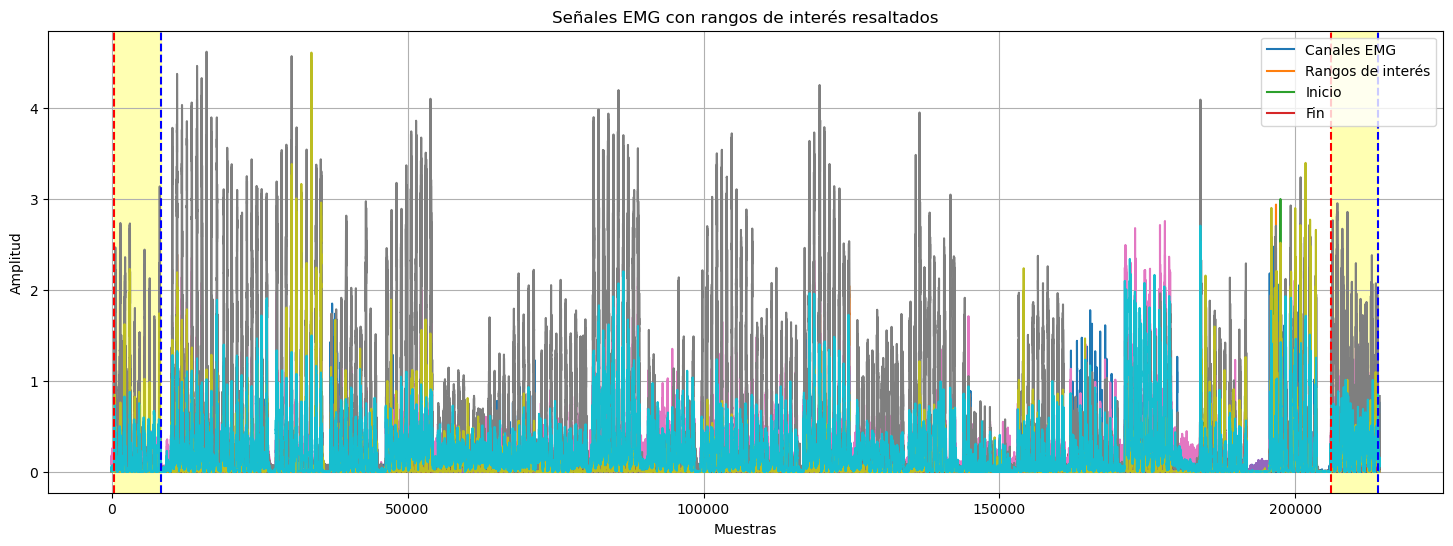

In [35]:
plt.figure(figsize=(18, 6))

# Graficar las señales EMG
for i in range(emg_s1.shape[1]):  # Iterar sobre cada canal de EMG
    plt.plot(emg_s1[:, i])

# Resaltar las regiones entre los rangos encontrados en index_ejercicios_s1
for exercise, (start, end) in index_ejercicios_s1.items():
    plt.axvspan(start, end, color='yellow', alpha=0.3, label=f'Ejercicio {exercise}')
    plt.axvline(x=start, color='red', linestyle='--', label=f'Inicio Ejercicio {exercise}')
    plt.axvline(x=end, color='blue', linestyle='--', label=f'Fin Ejercicio {exercise}')

# Configurar etiquetas y leyenda
plt.title('Señales EMG con rangos de interés resaltados')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(['Canales EMG', 'Rangos de interés', 'Inicio', 'Fin'])
plt.grid(True)

# Mostrar la gráfica
plt.show()

### Inspección de los datos de las posturas seleccionadas

Se realizara una inspección rapida de las muestras asociadas con las posturas 1 y 23.

#### Postura 1

In [36]:
print("Rango del ejercicio 1:", index_ejercicios_s1[1])

Rango del ejercicio 1: (386, 8322)


In [37]:
end_ex1 = index_ejercicios_s1[1][1]
end_ex1

8322

##### Grafica de la postura 1 empezando desde la muestra 0

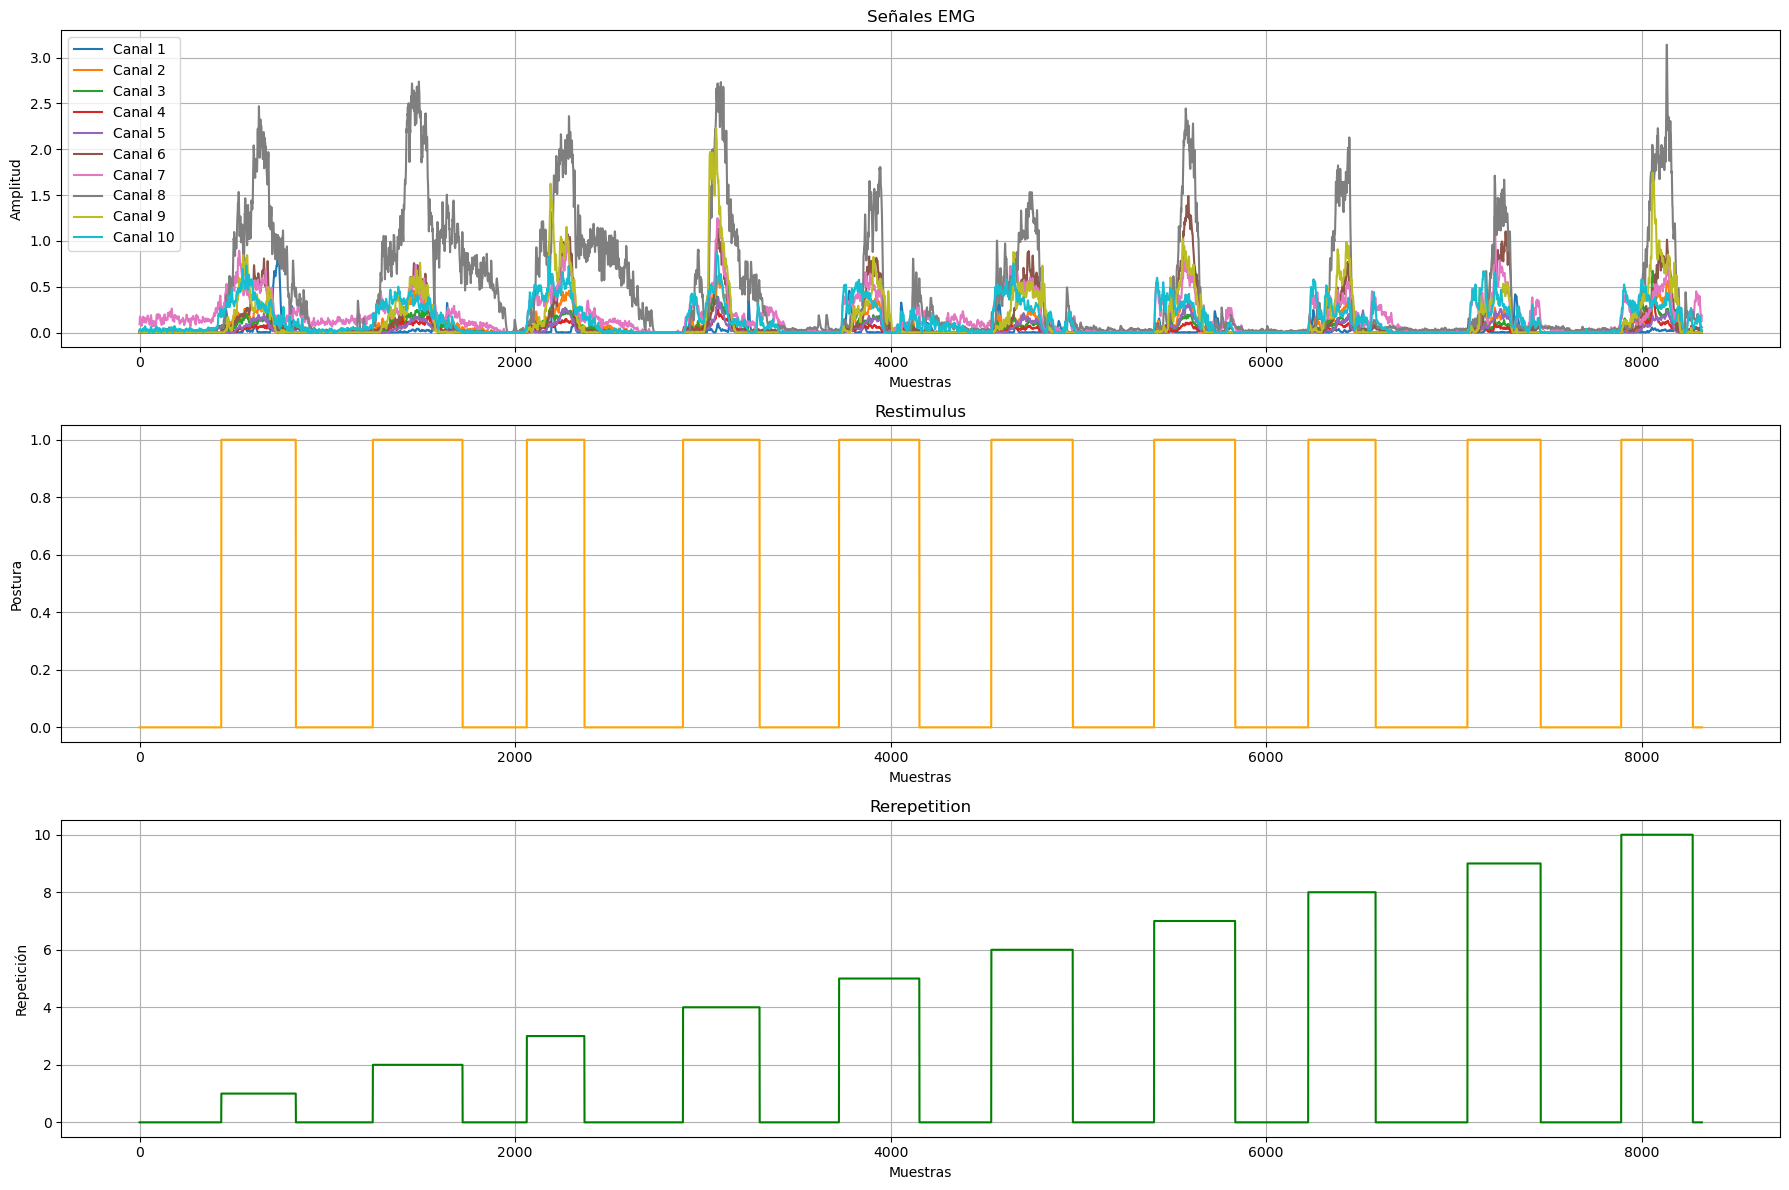

In [38]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1[:end_ex1, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1[:end_ex1], color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1[:end_ex1], color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

##### Grafica de la postura 1 dentro del rango obtenido

In [39]:
emg_s1_1 = emg_s1[index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1], :]
restimulus_s1_1 = restimulus_s1[index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1]]
rerepetition_s1_1 = rerepetition_s1[index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1]]

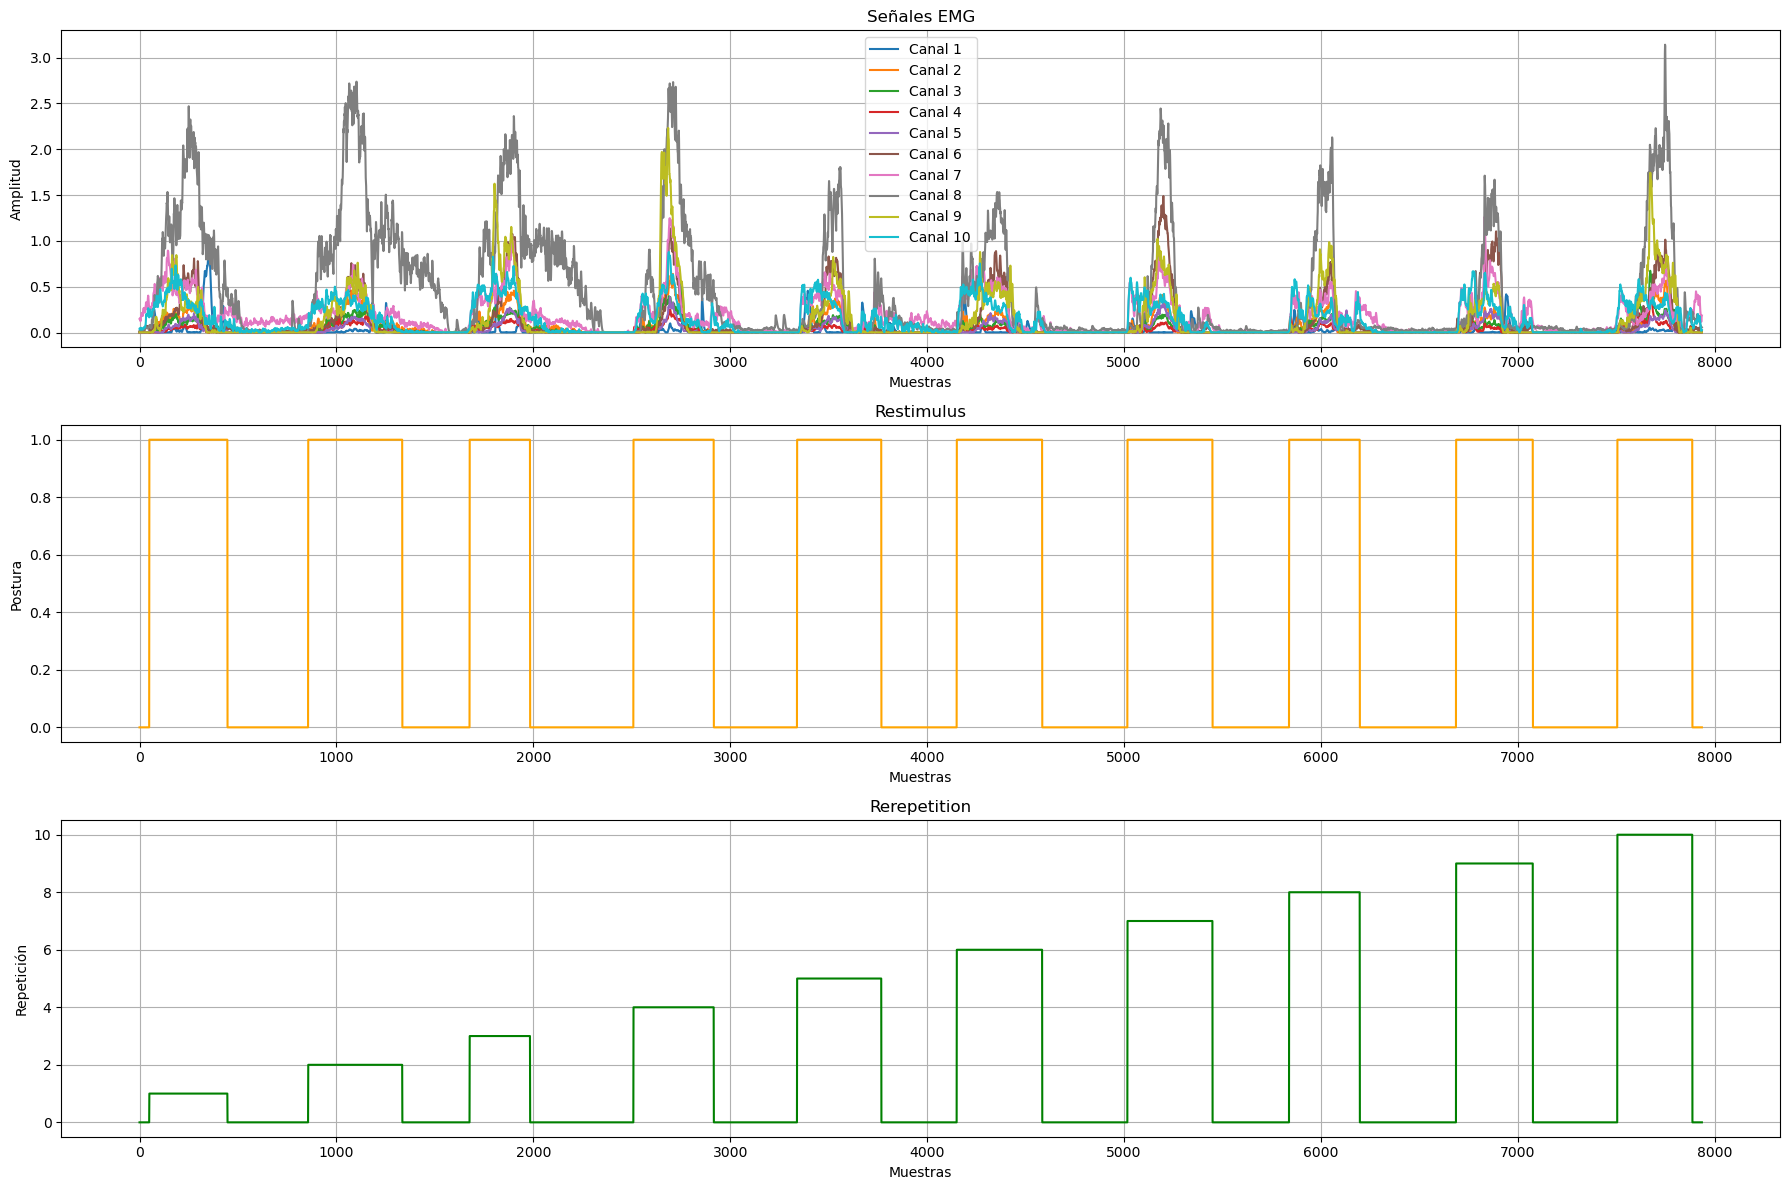

In [40]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1_1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1_1[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1_1, color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1_1, color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Portura 23

In [41]:
print(index_ejercicios_s1)

{1: (386, 8322), 23: (205923, 214023)}


In [42]:
index_ejercicios_s1[23]

(205923, 214023)

##### Grafica de la postura 23 dentro del rango obtenido

In [43]:
emg_s1_23 = emg_s1[index_ejercicios_s1[23][0]:index_ejercicios_s1[23][1], :]
restimulus_s1_23 = restimulus_s1[index_ejercicios_s1[23][0]:index_ejercicios_s1[23][1]]
rerepetition_s1_23 = rerepetition_s1[index_ejercicios_s1[23][0]:index_ejercicios_s1[23][1]]

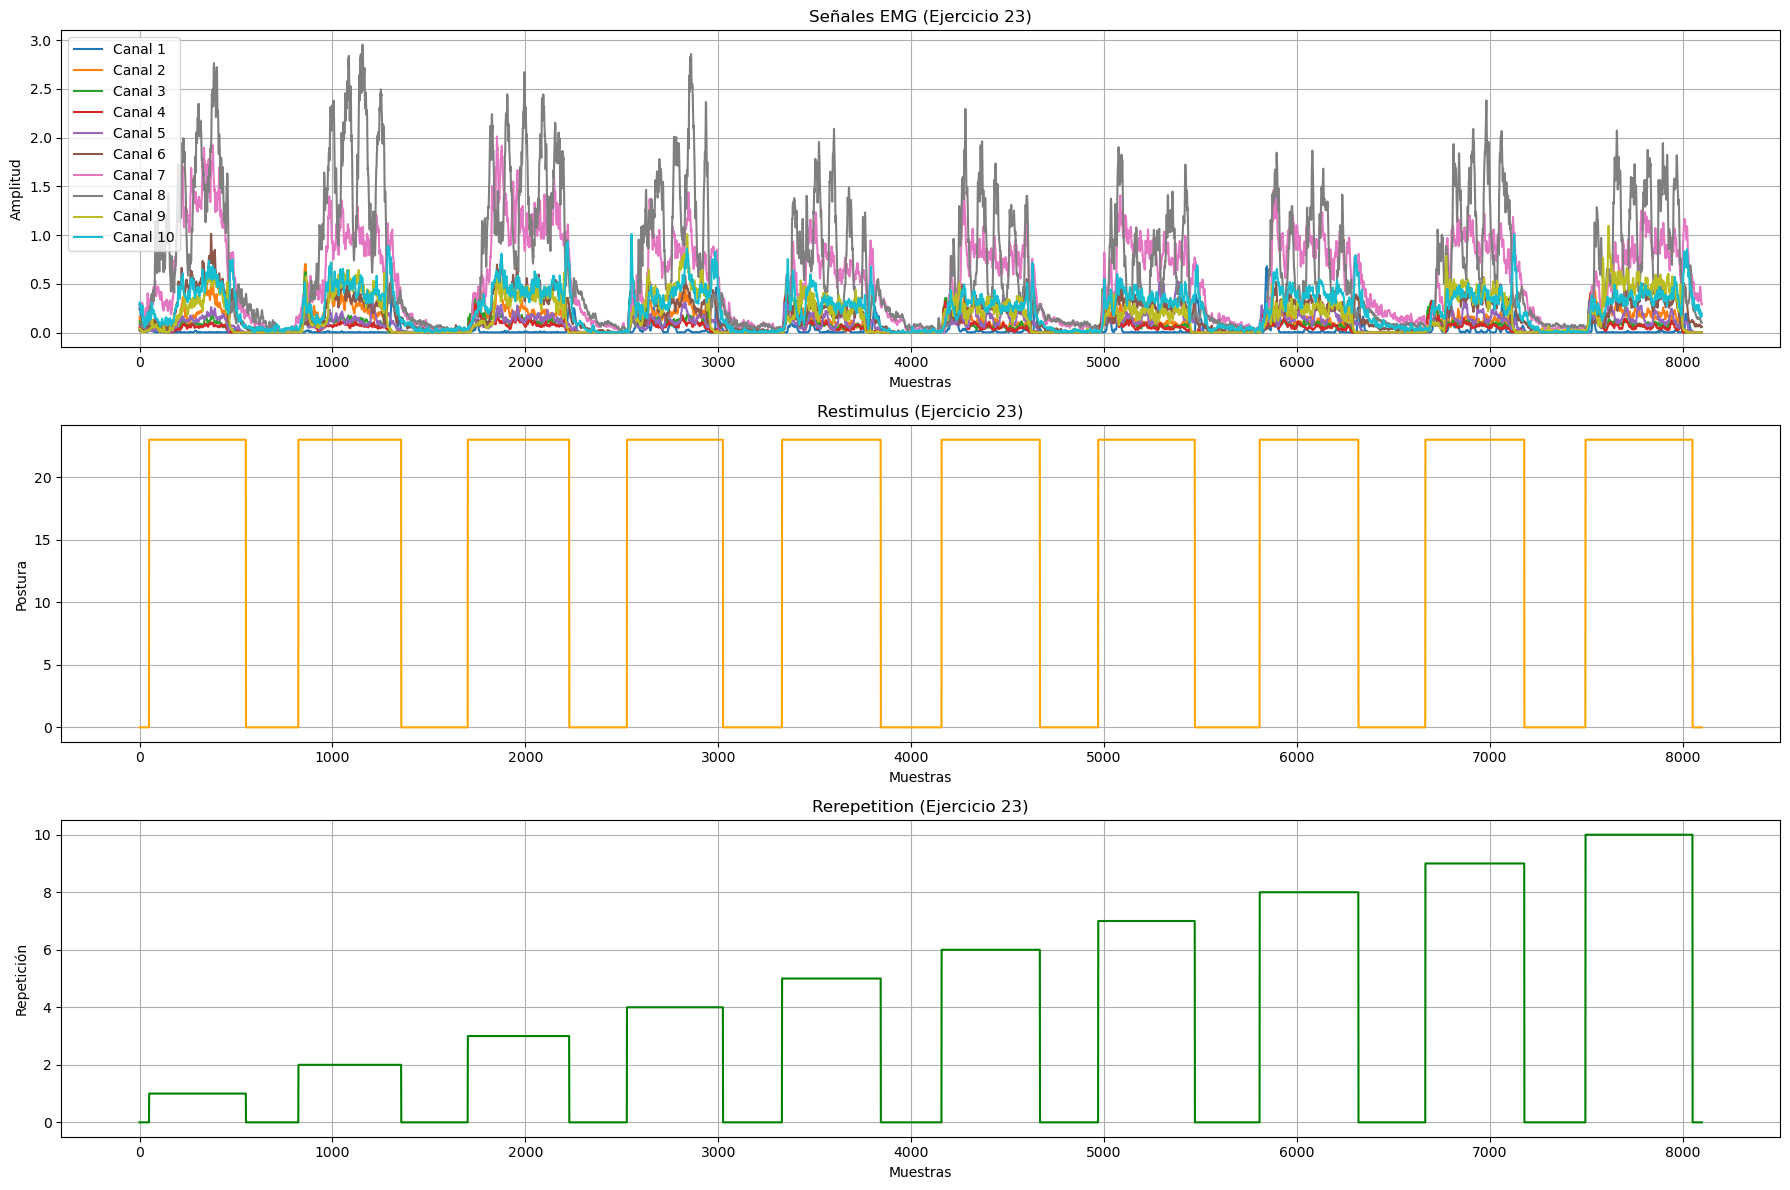

In [44]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1_23.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1_23[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG (Ejercicio 23)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1_23, color='orange')
plt.title('Restimulus (Ejercicio 23)')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1_23, color='green')
plt.title('Rerepetition (Ejercicio 23)')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Combinación de las posturas seleccionadas

A continuación, se realiza la combinación de las posturas seleccionadas como un solo dentro de una sola matriz. 

Tamaño de datos postura 1

In [48]:
data_s1_1 = data[INDEX_SUB][index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1], :]
data_s1_1.shape  # Mostrar la forma de los datos cargados

(7936, 12)

Tamaño de datos postura 23

In [49]:
data_s1_23 = data[INDEX_SUB][index_ejercicios_s1[23][0]:index_ejercicios_s1[23][1], :]
data_s1_23.shape  # Mostrar la forma de los datos cargados

(8100, 12)

Combinación de las posturas.

In [50]:
# Apilar las matrices data_s1_1 y data_s1_23
data_combined = np.vstack((data_s1_1, data_s1_23))
data_combined.shape  # Mostrar la forma de la matriz combinada

(16036, 12)

Se seleccionan los grupos de datos asociados a los diferentes tipos de señales.

In [51]:
emg_combined = data_combined[:, 0:10]
restimulus_combined = data_combined[:, 10]
rerepetition_combined = data_combined[:, 11]

##### Grafica con la combinación de las señales 1 y 23 seleccionadas

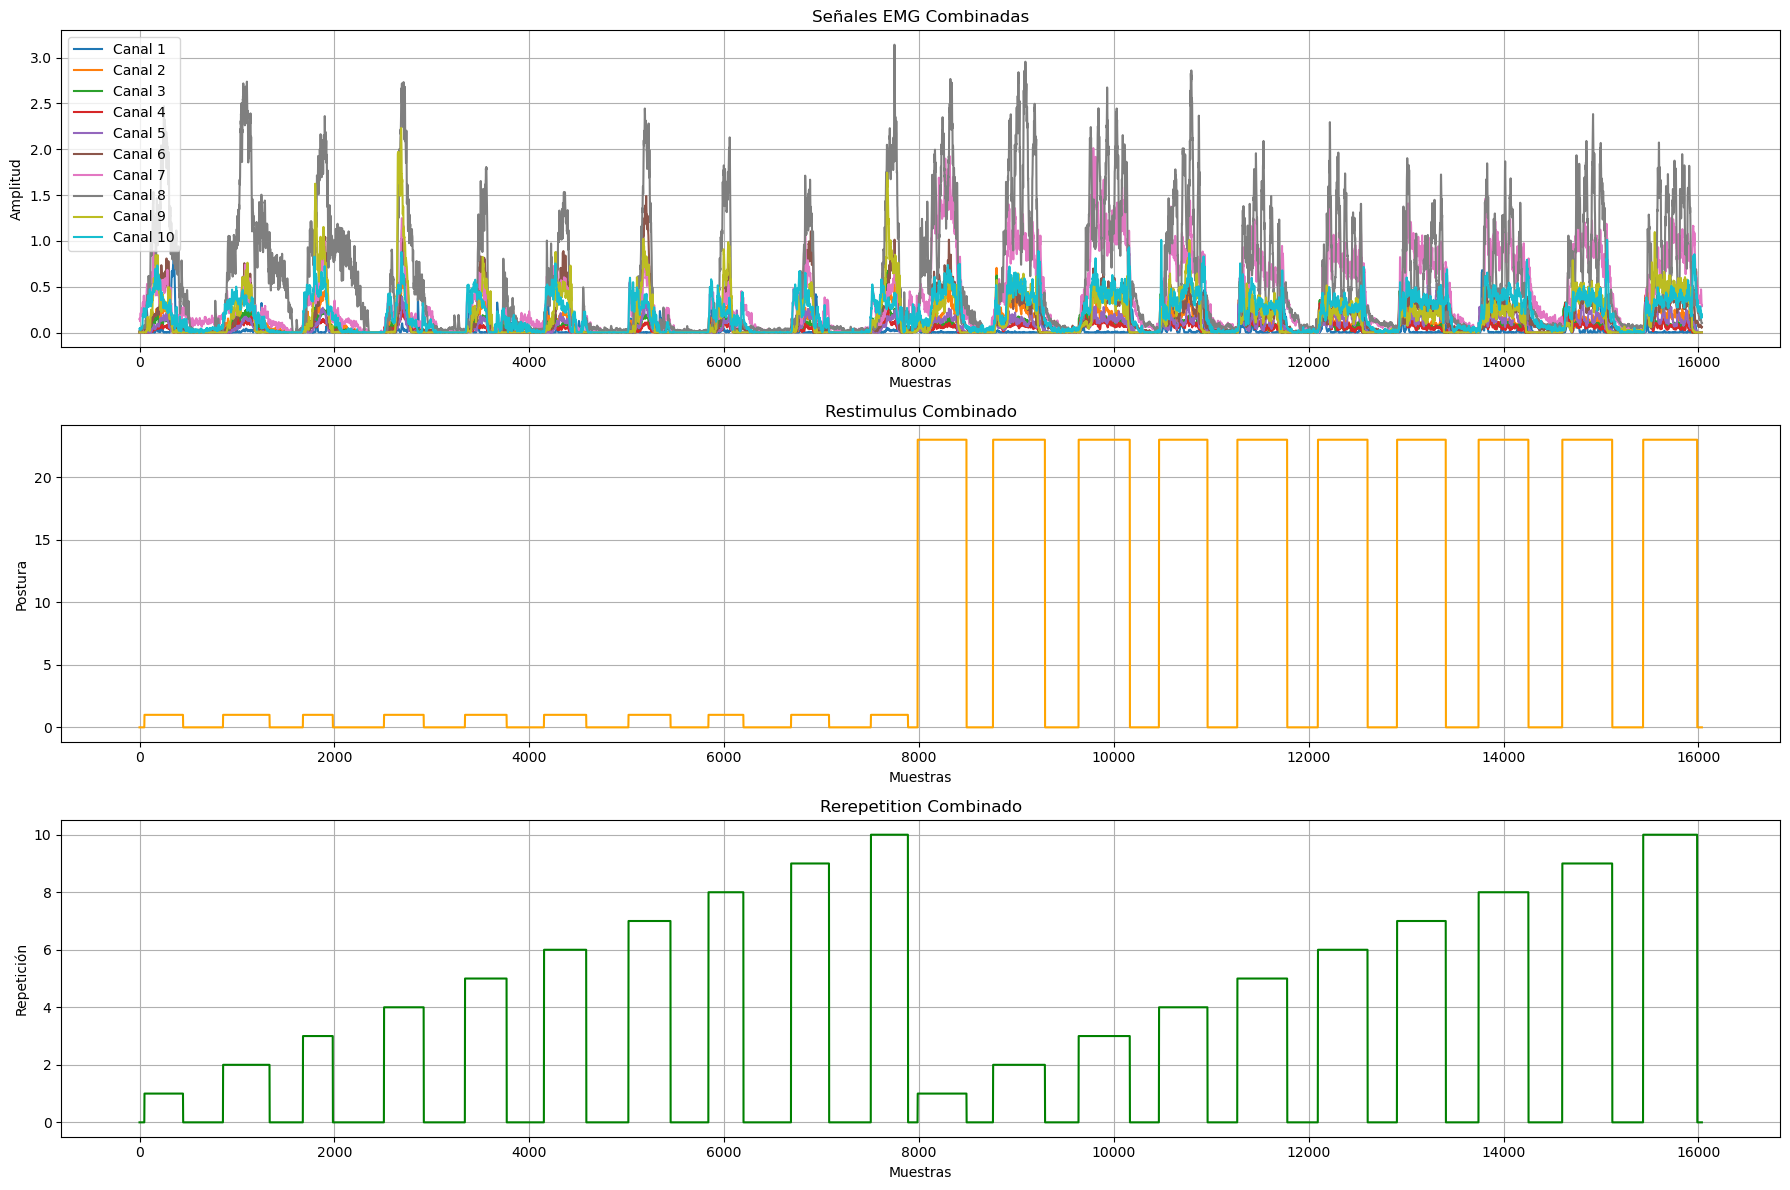

In [52]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_combined.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_combined[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG Combinadas')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_combined, color='orange')
plt.title('Restimulus Combinado')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_combined, color='green')
plt.title('Rerepetition Combinado')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Generalización del procedimiento de combinación de datos

La siguiente función generaliza el procedimiento.

In [53]:
def get_samples_by_exercises(data, exercise_numbers):
    """
    Obtiene las muestras correspondientes a un ejercicio específico.

    Parámetros:
        data (numpy.ndarray): Matriz de datos completa.
        exercise_numbers (list): Lista de números de ejercicios a extraer.

    Retorna:
        numpy.ndarray: Subconjunto de datos correspondiente al ejercicio especificado.
    """

    left_margin = 50  # Margen izquierdo
    right_margin = 50  # Margen derecho
    exercise_index = get_multiple_exercise_ranges(data[:,10], exercise_numbers, (left_margin,right_margin))
    exercise_samples = []
    for exercise_number, (start, end) in exercise_index.items():
        # Filtrar las filas donde el estímulo coincide con el número del ejercicio
        exercise_samples.append(data[start:end, :])
    # Apilar los resultados en una sola matriz
    return np.vstack(exercise_samples)  

#### Prueba de la funcion para el mismo ejemplo anterior

In [54]:
data[INDEX_SUB].shape  # Mostrar la forma de los datos cargados

(214236, 12)

In [55]:
data_s1_ex_1_23 = get_samples_by_exercises(data[INDEX_SUB], [1, 23])  # Obtener muestras de los ejercicios 1 y 23

In [56]:
data_s1_ex_1_23.shape

(16036, 12)

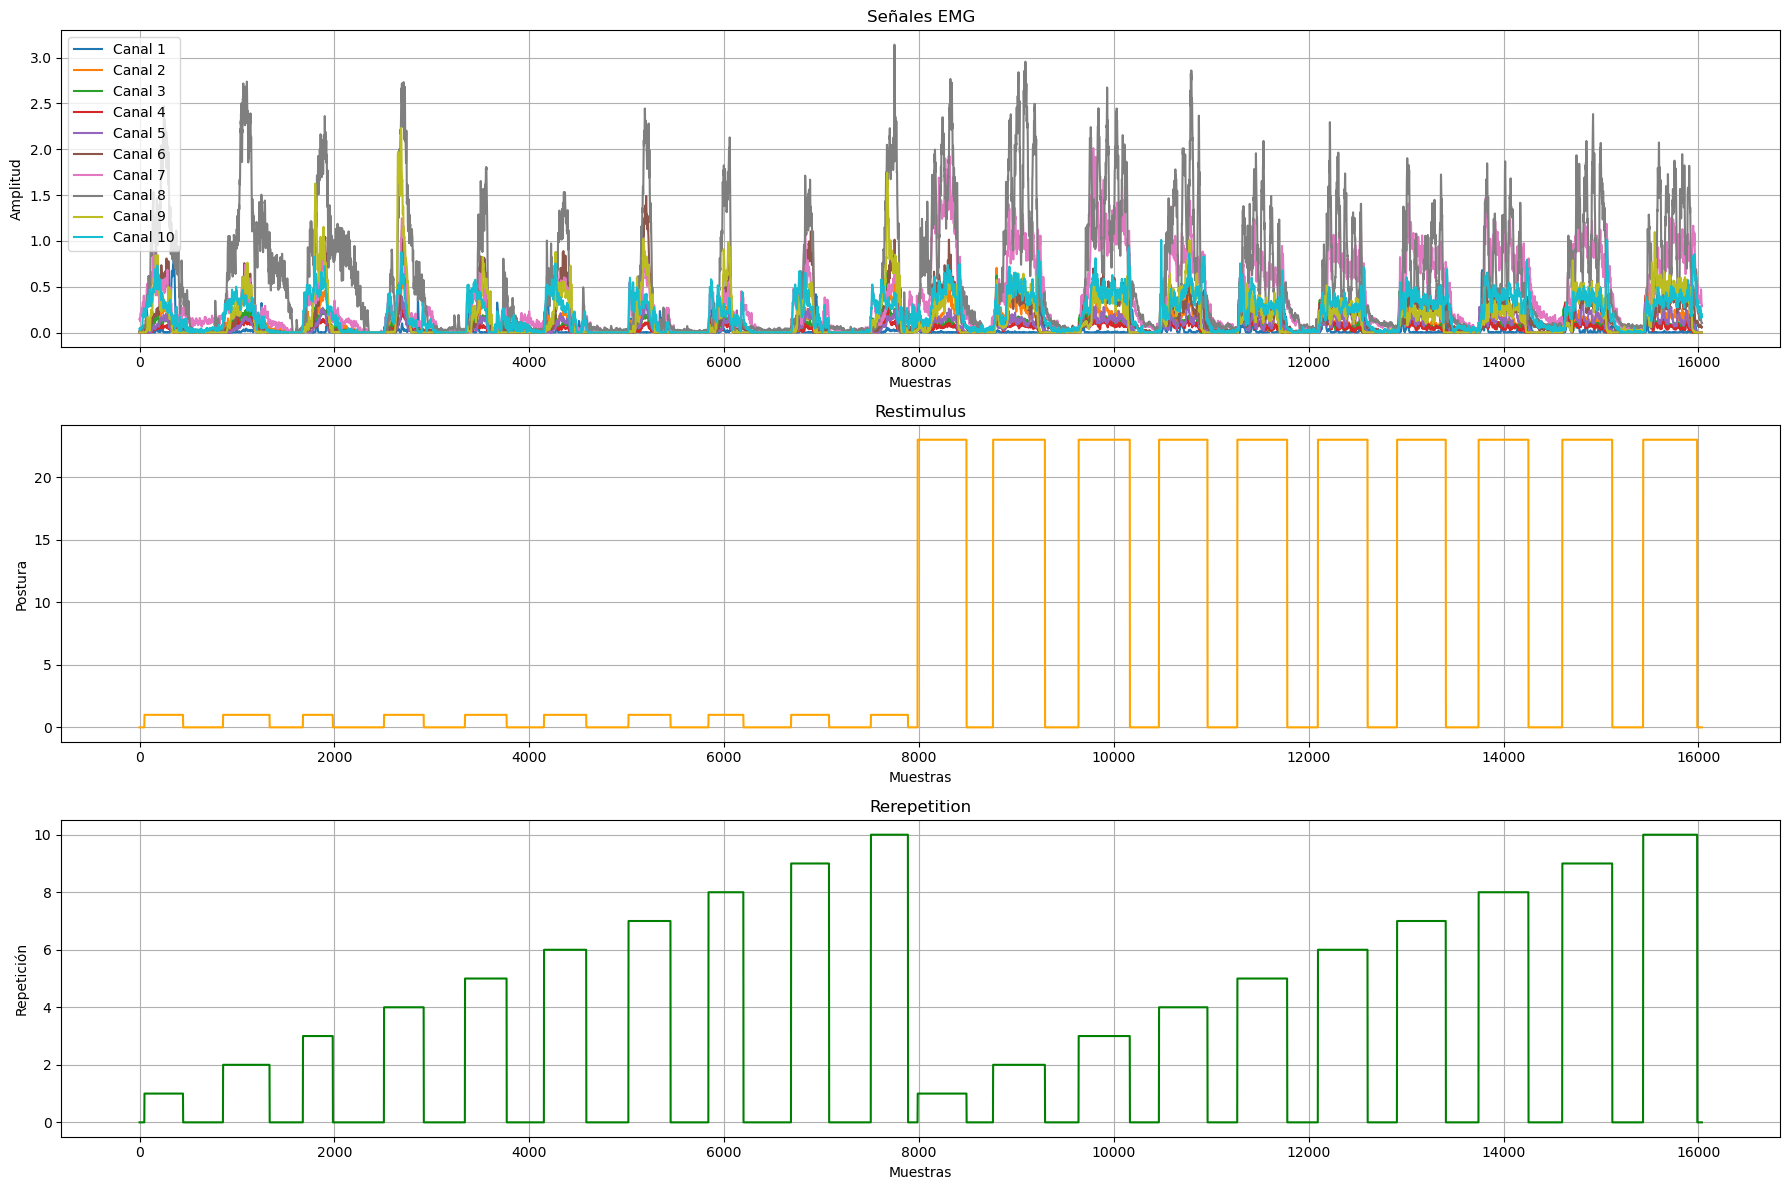

In [57]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals (first 10 columns)
plt.subplot(3, 1, 1)
for i in range(10):  # Iterate over the first 10 columns
    plt.plot(data_s1_ex_1_23[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus (column 10)
plt.subplot(3, 1, 2)
plt.plot(data_s1_ex_1_23[:, 10], color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition (column 11)
plt.subplot(3, 1, 3)
plt.plot(data_s1_ex_1_23[:, 11], color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

La conclusión es que al parecer el procedimiento funciona de acuerdo a lo que se espera de este.

### Selección de los datos de las posturas para todos los sujetos del dataset

El el siguiente procedimiento se seleccionan las posturas de interes de todos los sujetos y se almacenan para analisis posteriores.

In [58]:
type(data)

dict

In [59]:
selected_exercises = [1, 23]  # Ejercicios seleccionados
data_for_selected_exercises = {}
for subject in data.keys():
    data_for_selected_exercises[subject] = get_samples_by_exercises(data[subject], selected_exercises)
    # Obtener muestras de los ejercicios seleccionados para cada sujeto
    print(f"Sujeto {subject}: {data_for_selected_exercises[subject].shape} muestras obtenidas para los ejercicios {selected_exercises}")

Sujeto 1: (16036, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 10: (15988, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 11: (16099, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 12: (15930, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 13: (16007, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 14: (15864, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 15: (15937, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 16: (16001, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 17: (16034, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 18: (15985, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 19: (16116, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 2: (15973, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 20: (15972, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 21: (16109, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 22: (16003, 12)

In [60]:
len(data_for_selected_exercises)

27

Se realiza la verificación de los datos cargados con el sujeto de prueba para verificación del procedimiento con respecto a lo realizado al inicio.

In [61]:
INDEX_SUB

'1'

In [62]:
data_for_selected_exercises[INDEX_SUB].shape  # Mostrar la forma de los datos del primer sujeto

(16036, 12)

### Almacenamiento de los datos crudos a analizar

Los datos crudos a analizar se almacenarán en el directorio **`RAW_SUBSET_DATA_DIR`** siguiendo la nomenclatura `raw_subset_s{x}_p{1_2_*}_E3.npy`. Donde:
* **`s_{x}`**: Numero del sujeto.
* **`p_{nums}`**: Numero de las posturas seleccionadas.
* **`E3`**: Por que las posturas que se usan son las asociadas al ejercicio 3.

**Nota**: Se sobreentiende que la postura 0 va pues es asociada a la posición de descanso.

In [63]:
RAW_SUBSET_DATA_DIR

'c:\\Users\\Usuario\\Documents\\UdeA\\especializacion\\repos\\monografia\\data\\raw_subset'

In [64]:
selected_exercises

[1, 23]

Se realiza una inspección rapida de los datos antes de almacenarlos.

In [65]:
data_for_selected_exercises

{'1': array([[0.0024, 0.0024, 0.0024, ..., 0.0415, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.0464, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.0464, 0.    , 0.    ],
        ...,
        [0.0024, 0.0024, 0.0024, ..., 0.1904, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.1807, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.1733, 0.    , 0.    ]]),
 '10': array([[0.2686, 0.1196, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.2588, 0.1074, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.2319, 0.0879, 0.0024, ..., 0.0024, 0.    , 0.    ],
        ...,
        [0.1636, 0.0024, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.1367, 0.0024, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.1123, 0.0024, 0.0024, ..., 0.0024, 0.    , 0.    ]]),
 '11': array([[0.0122, 0.0024, 0.0024, ..., 0.0562, 0.    , 0.    ],
        [0.0098, 0.0024, 0.0024, ..., 0.0537, 0.    , 0.    ],
        [0.0073, 0.0024, 0.0024, ..., 0.0537, 0.    , 0.    ],
        

In [66]:
# Crear el directorio si no existe
os.makedirs(RAW_SUBSET_DATA_DIR, exist_ok=True)

# Almacenar cada np.array en un archivo .npy
for idx, subject_data in data_for_selected_exercises.items():
    file_name = f"raw_subset_s{idx}_p{'_'.join(map(str, selected_exercises))}_E3.npy"
    file_path = os.path.join(RAW_SUBSET_DATA_DIR, file_name)
    np.save(file_path, subject_data)
    print(f"Archivo guardado: {file_path}")

Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s1_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s10_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s11_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s12_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s13_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s14_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s15_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s1

## Conclusiones

Al finalizar este notebook se logro.
* Seleccionar las posturas seleccionadas para los ejercicios 1 y 23 incluyendo los descansos.
* Almacenar estos datos para todos los sujetos para analisis posteriores.